In [43]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the data
file_path = '/content/drive/MyDrive/UNSW_NB15_training-set.csv'
data = pd.read_csv(file_path)

In [4]:
#Count number of entries for each categories
data.attack_cat.value_counts()

attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

In [5]:
#check number of column header
print(data.columns)

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')


In [6]:
# Define a mapping from category to numerical value
category_mapping = {
    'Normal': 0,
    'Generic': 1,
    'Exploits': 2,
    'Fuzzers': 3,
    'DoS': 4,
    'Reconnaissance':5
}

# Apply the mapping to the 'attack_cat' column
data['attack_cat'] = data['attack_cat'].map(category_mapping)

In [7]:
# Keep only the rows in 'attack_cat' to match the mapping
data = data[data['attack_cat'].isin([0, 1, 2, 3, 4, 5])]

In [8]:
# Save the modified DataFrame to a csv file
data.to_csv('modified_data.csv', index=False)

In [9]:
# Print the first 5 rows of the DataFrame
print(data.head())

   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0                 0   

In [10]:
# Identify columns with non-numerical data
non_numeric_cols = data.select_dtypes(exclude=['number']).columns
print("Non-numerical columns:", non_numeric_cols)

#handle non-numerical columns
data = data.drop(non_numeric_cols, axis=1)

Non-numerical columns: Index(['proto', 'service', 'state'], dtype='object')


In [11]:
# Save the modified DataFrame to a csv file
data.to_csv('modified_data.csv', index=False)

In [12]:
#Count number of entries for each categories
data.attack_cat.value_counts()

attack_cat
0.0    56000
1.0    40000
2.0    33393
3.0    18184
4.0    12264
5.0    10491
Name: count, dtype: int64

**Initial dataset**

In [13]:
# Load the dataset
data = pd.read_csv('modified_data.csv')

# Separate features and target
X = data.drop(['attack_cat'], axis=1)
y = data['attack_cat']

# Convert 'attack_cat' to integer type
y = y.astype('int32')

# Number of classes
num_classes = y.nunique()

# Convert class vectors to binary class matrices (one-hot encoding)
y = to_categorical(y, num_classes)

# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialize the ANN
model = Sequential()

# Add the input layer and the first hidden layer with dropout
model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.05))

# Add the second hidden layer with dropout
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.075))

# Add the third hidden layer with dropout
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.1))

# Add the output layer
model.add(Dense(units=num_classes, activation='softmax'))

# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the ANN
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the ANN on the training set
model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=200, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Epoch 1/200
3407/3407 [==============================] - 16s 4ms/step - loss: 0.4372 - accuracy: 0.8287 - val_loss: 0.3676 - val_accuracy: 0.8551
Epoch 2/200
3407/3407 [==============================] - 11s 3ms/step - loss: 0.3558 - accuracy: 0.8575 - val_loss: 0.3352 - val_accuracy: 0.8625
Epoch 3/200
3407/3407 [==============================] - 18s 5ms/step - loss: 0.3345 - accuracy: 0.8650 - val_loss: 0.3228 - val_accuracy: 0.8714
Epoch 4/200
3407/3407 [==============================] - 22s 6ms/step - loss: 0.3256 - accuracy: 0.8675 - val_loss: 0.3206 - val_accuracy: 0.8689
Epoch 5/200
3407/3407 [==============================] - 9s 3ms/step - loss: 0.3176 - accuracy: 0.8701 - val_loss: 0.3092 - val_accuracy: 0.8731
Epoch 6/200
3407/3407 [==============================] - 11s 3ms/step - loss: 0.3133 - accuracy: 0.8709 - val_loss: 0.3020 - val_accuracy: 0.8757
Epoch 7/200
3407/3407 [==============================] - 11s 3ms/step - loss: 0.3091 - accuracy: 0.8724 - val_loss: 0.3014 - 

1065/1065 [==============================] - 2s 1ms/step


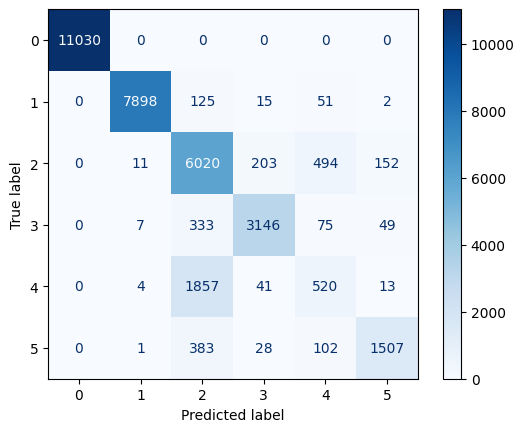

Train ROC AUC Score: 0.8820837385553767
Test ROC AUC Score: 0.8785604035308149


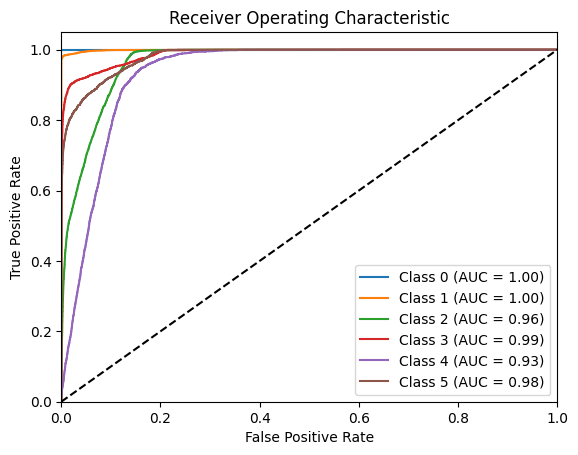

In [14]:
# Predict probabilities
y_train_prob = model.predict(X_train)
y_test_prob = model.predict(X_test)

# Convert probabilities to classes
y_train_pred = np.argmax(y_train_prob, axis=1)
y_test_pred = np.argmax(y_test_prob, axis=1)

# Confusion Matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5])# 6
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Save Confusion Matrix to .npy file
np.save('confusion_matrix_initial.npy', cm)

# Save true labels and predicted probabilities
np.save('y_test_initial.npy', np.argmax(y_test, axis=1))  # True labels
np.save('y_pred_proba_initial.npy', y_test_prob)  # Predicted probabilities

# Compute ROC AUC
lb = LabelBinarizer()
lb.fit(y_train)
y_train_lb = lb.transform(y_train)
y_test_lb = lb.transform(y_test)
y_train_pred_lb = lb.transform(y_train_pred)
y_test_pred_lb = lb.transform(y_test_pred)

roc_auc_train = roc_auc_score(y_train_lb, y_train_pred_lb, multi_class='ovr')
roc_auc_test = roc_auc_score(y_test_lb, y_test_pred_lb, multi_class='ovr')

print(f"Train ROC AUC Score: {roc_auc_train}")
print(f"Test ROC AUC Score: {roc_auc_test}")

# Save ROC AUC Scores to .npy file
roc_auc_scores = {'train': roc_auc_train, 'test': roc_auc_test}
np.save('roc_auc_scores_initial.npy', roc_auc_scores)

# Plot ROC curves
fig, ax = plt.subplots()
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_lb[:, i], y_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Class {i}')
    display.plot(ax=ax) # Plot on the same axe

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
# Define the path to save files in Google Drive
save_path = '/content/drive/My Drive/'

# Save Confusion Matrix to .npy file
np.save(save_path + 'confusion_matrix_initial.npy', cm)

# Save true labels and predicted probabilities for later use
np.save(save_path + 'y_test_initial.npy', np.argmax(y_test, axis=1))  # True labels
np.save(save_path + 'y_pred_proba_initial.npy', y_test_prob)  # Predicted probabilities

# Save ROC AUC Scores to .npy file
roc_auc_scores = {'train': roc_auc_train, 'test': roc_auc_test}
np.save(save_path + 'roc_auc_scores_initial.npy', roc_auc_scores)

**Generating Synthetic data - implement CTGAN the dataset**

In [16]:
!pip install sdv -v
!pip install numpy pandas scikit-learn torch
!pip install ctgan

Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Link requires a different Python (3.10.12 not in: '>=3.5,<3.8'): https://files.pythonhosted.org/packages/cb/fa/ac29dd9bf40ba191a35feca8e6d879dd29e6fdd621a6bc30966eb50fc356/sdv-0.3.3-py2.py3-none-any.whl (from https://pypi.org/simple/sdv/) (requires-python:>=3.5,<3.8)
  Link requires a different Python (3.10.12 not in: '>=3.5,<3.8'): https://files.pythonhosted.org/packages/75/1b/54a2a87d2f534d2108f80b5b1040029460b468ef933949777dcfb46314a4/sdv-0.3.3.tar.gz (from https://pypi.org/simple/sdv/) (requires-python:>=3.5,<3.8)
  Link requires a different Python (3.10.12 not in: '>=3.5,<3.8'): https://files.pythonhosted.org/packages/08/e2/dd15644adc514f720a0f5400d2c3f6a950172e74665fdea5687de792cd2e/sdv-0.3.4.dev0-py2.py3-none-any.whl (from https://pypi.org/simple/sdv/) (requires-python:>=3.5,<3.8)
  Link requires a different Python (3.10.12 not in: '>=3.5,<3.8'): https://files.pythonhosted.org/packages/01/6c/90dc54

In [17]:
from ctgan import CTGAN
from sklearn.preprocessing import LabelEncoder

In [18]:
# Load the dataset
data = pd.read_csv('modified_data.csv')

# Preprocessing
le = LabelEncoder()
for column in data.select_dtypes(include=['object']).columns:
    data[column] = le.fit_transform(data[column].astype(str))

# Ensure 'attack_cat' is encoded as integers 0, 1, 2
data['attack_cat'] = le.fit_transform(data['attack_cat'])

# Split the data
X = data.drop('label', axis=1)
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = pd.concat([X_train, y_train], axis=1)

# Initialize and fit CTGAN
ctgan = CTGAN(
    epochs=100,
    batch_size=200,
    log_frequency=True,
    verbose=True
)
ctgan.fit(train_data)

# Generate synthetic data
num_synthetic_samples = len(train_data)
synthetic_data = ctgan.sample(num_synthetic_samples)

# Ensure 'attack_cat' in synthetic data is encoded correctly
synthetic_data['attack_cat'] = le.transform(synthetic_data['attack_cat'])

# Add the original labels to the synthetic data
synthetic_data['label'] = train_data['label'].values[:num_synthetic_samples]

# Print the first few rows of the synthetic data
print(synthetic_data.head())

# Save the synthetic data
synthetic_data.to_csv('synthetic_UNSW_NB15_modified_data.csv', index=False)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
Gen. (-2.94) | Discrim. (1.43): 100%|██████████| 10/10 [16:21<00:00, 98.16s/it] 


       id       dur  spkts  dpkts  sbytes  dbytes           rate  sttl  dttl  \
0  178227  0.000658     -3      0     640     571  194645.053238   254     1   
1   63103  0.721312      3      9     814     153   -1076.775723   254   251   
2   76861  0.340536      6      5     888     401     218.090034   254   252   
3   98779  0.776017     54      6    2769    8455    -245.460109    62   251   
4   69383  1.983256      2      8     106    1168    -488.247226   254   253   

          sload  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0  5.080683e+07  ...                13              30             0   
1  5.673710e+05  ...                 1               3             0   
2  1.460451e+04  ...                 1               2             0   
3  1.424072e+06  ...                 1               1             0   
4 -7.411910e+05  ...                 1               9             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0         

In [19]:
# Identify columns with non-numerical data
non_numeric_cols = data.select_dtypes(exclude=['number']).columns
print("Non-numerical columns:", non_numeric_cols)

#handle non-numerical columns
data = data.drop(non_numeric_cols, axis=1)

Non-numerical columns: Index([], dtype='object')


In [20]:
# Save the modified DataFrame to a csv file
data.to_csv('synthetic_UNSW_NB15_modified_data.csv', index=False)

In [21]:
#Count number of entries for each categories
data.attack_cat.value_counts()

attack_cat
0    56000
1    40000
2    33393
3    18184
4    12264
5    10491
Name: count, dtype: int64

In [22]:
# Check for NaN values in y_test_lb and y_test_prob
print("NaN values in y_test_lb:", np.isnan(y_test_lb).sum())
print("NaN values in y_test_prob:", np.isnan(y_test_prob).sum())

# Handle NaN values by removing rows with NaN values
y_test_lb = y_test_lb[~np.isnan(y_test_lb).any(axis=1)]
y_test_prob = y_test_prob[~np.isnan(y_test_prob).any(axis=1)]

# Ensure the arrays are still aligned after removing NaN values
assert y_test_lb.shape[0] == y_test_prob.shape[0], "Mismatch in array lengths after removing NaN values"

# Print the updated shape of y_test_lb and y_test_prob to debug
print("Updated y_test_lb shape:", y_test_lb.shape)
print("Updated y_test_prob shape:", y_test_prob.shape)

# Save the modified DataFrame to a csv file
save_path = '/content/drive/My Drive/'
data.to_csv(save_path + 'synthetic_UNSW_NB15_modified_data.csv', index=False)


NaN values in y_test_lb: 0
NaN values in y_test_prob: 0
Updated y_test_lb shape: (34067, 6)
Updated y_test_prob shape: (34067, 6)


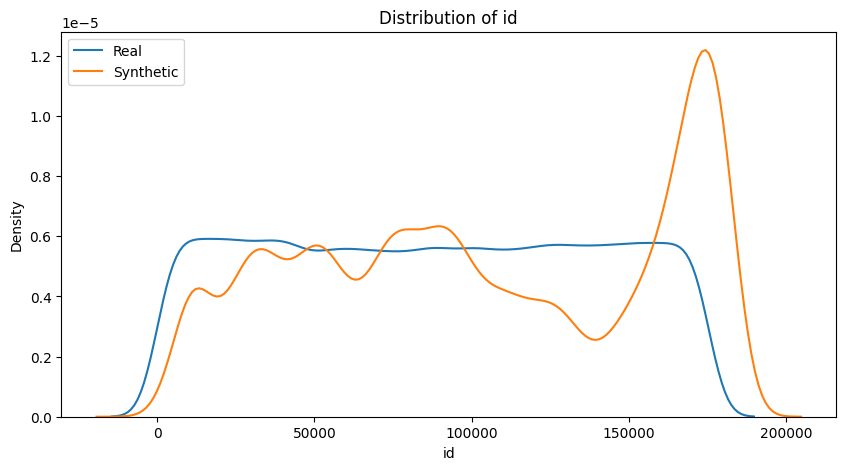

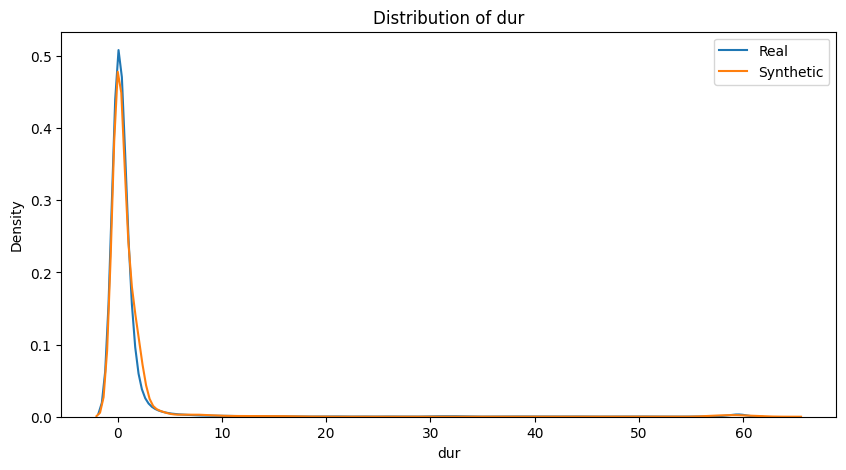

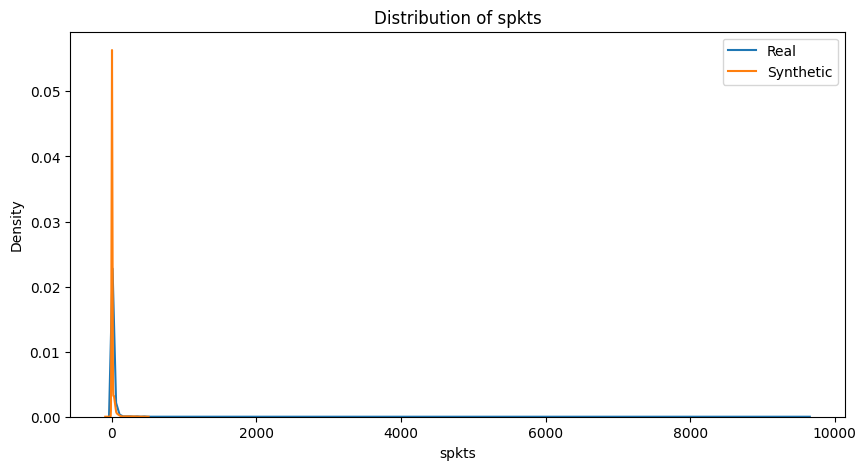

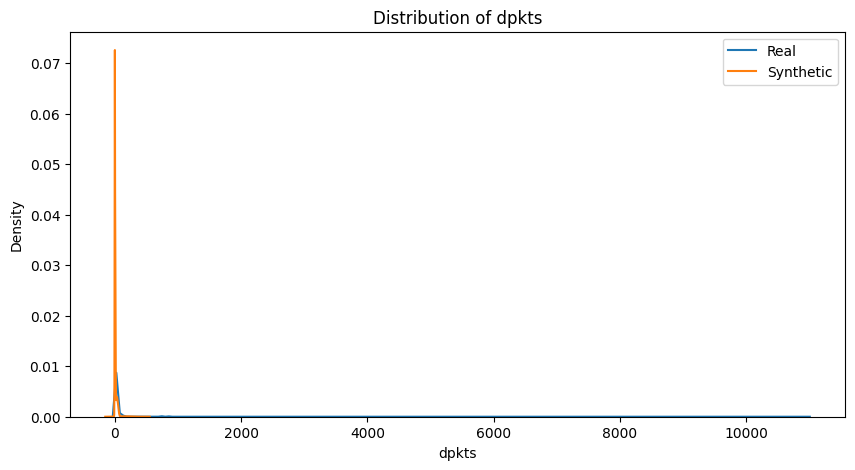

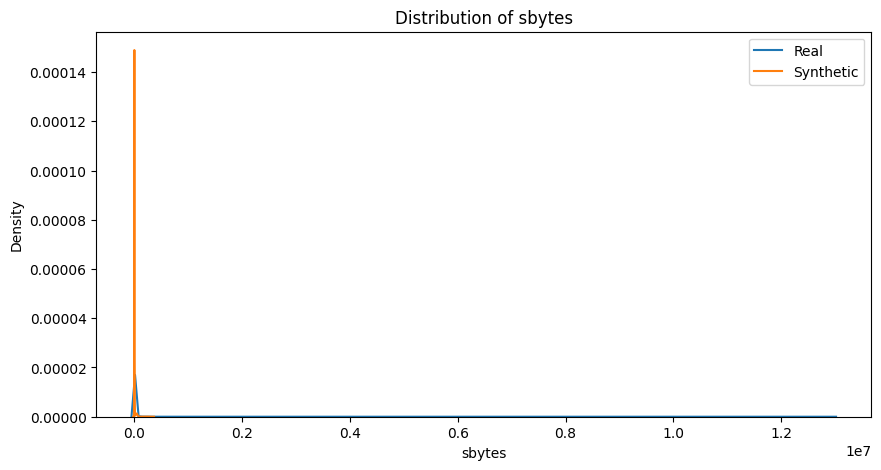

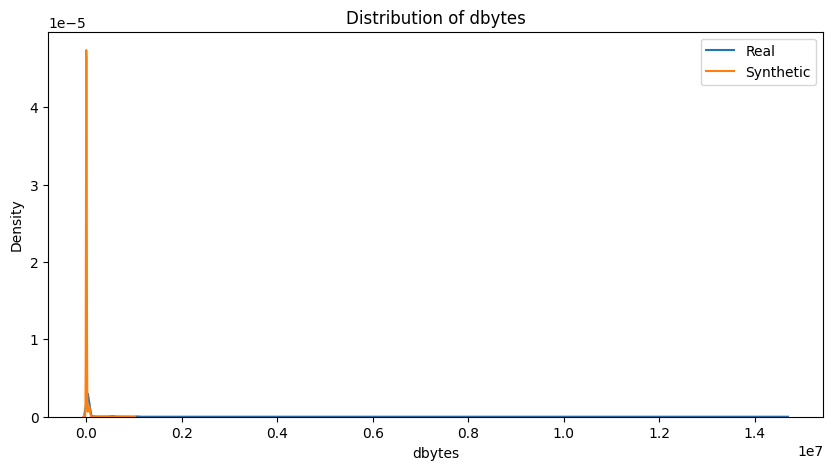

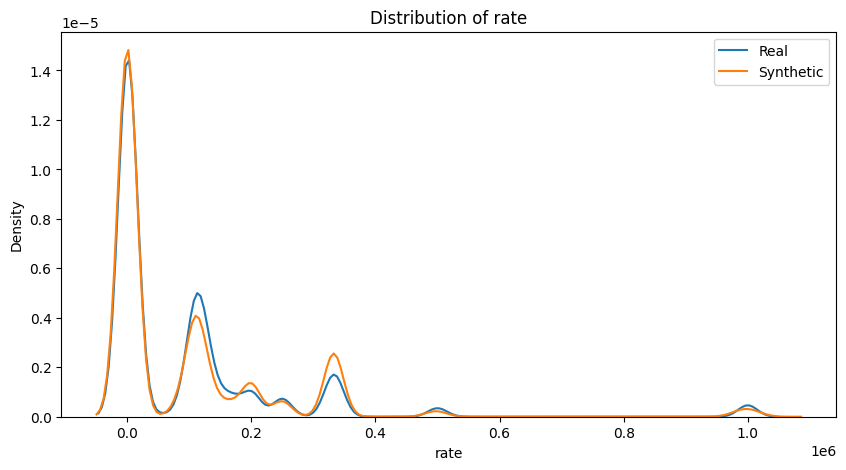

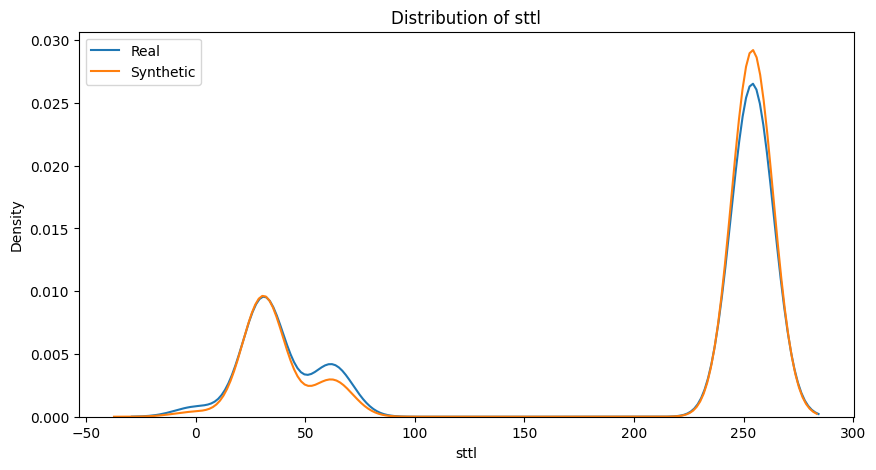

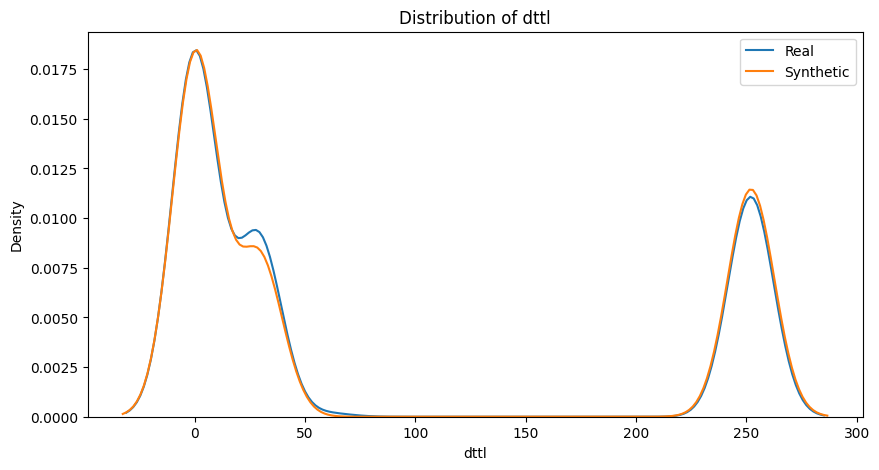

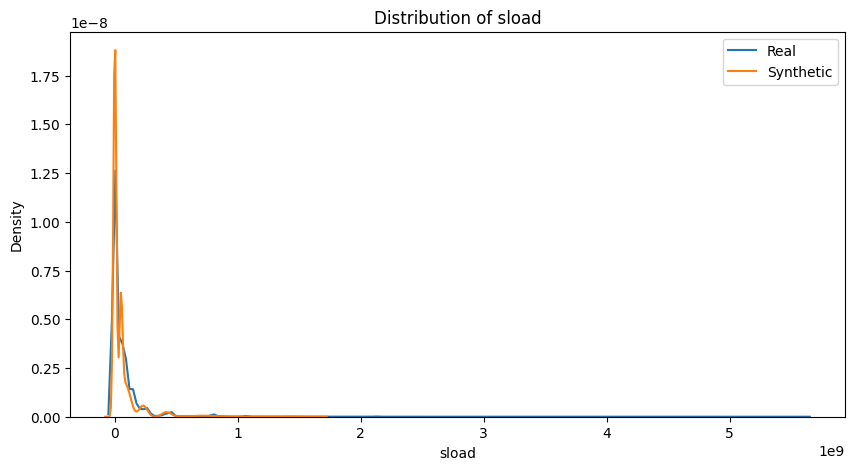

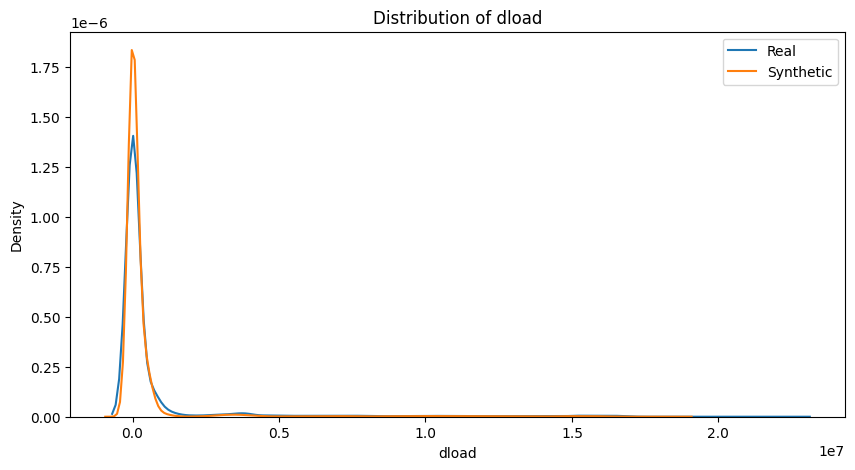

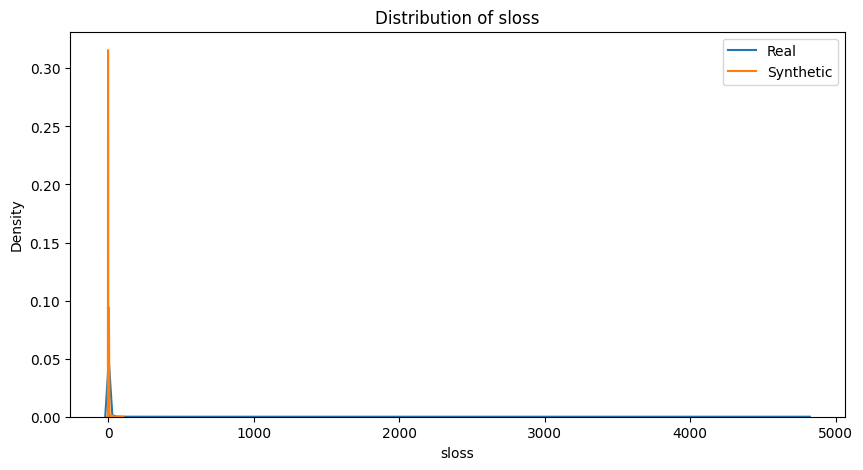

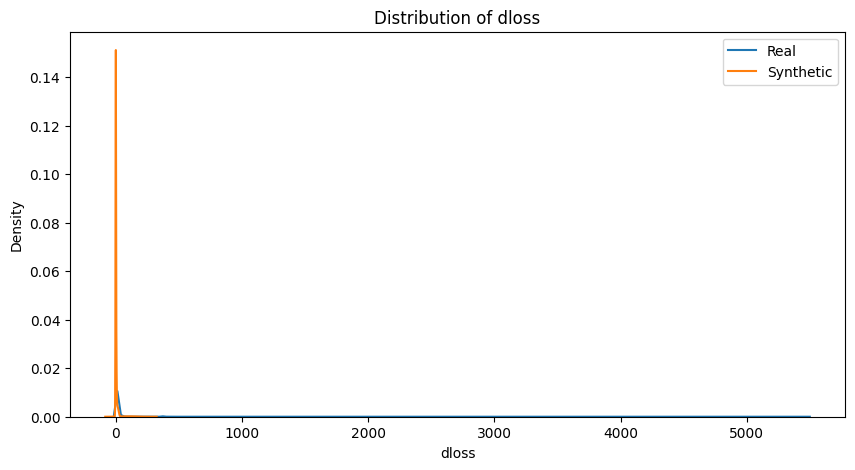

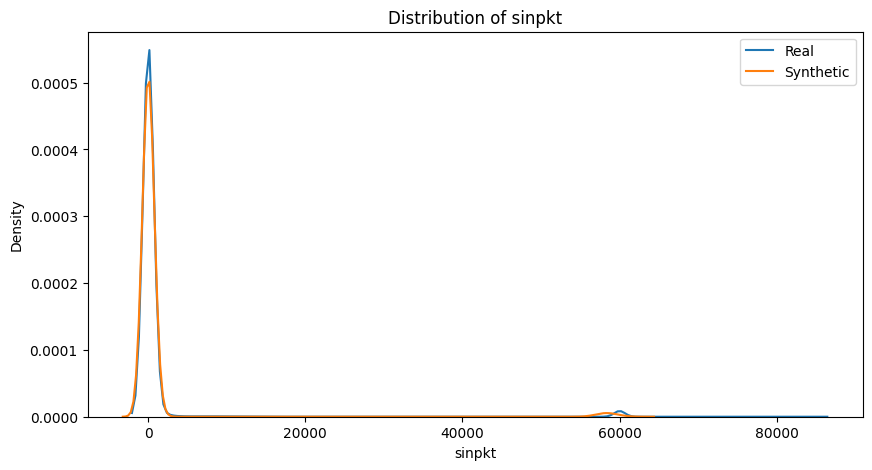

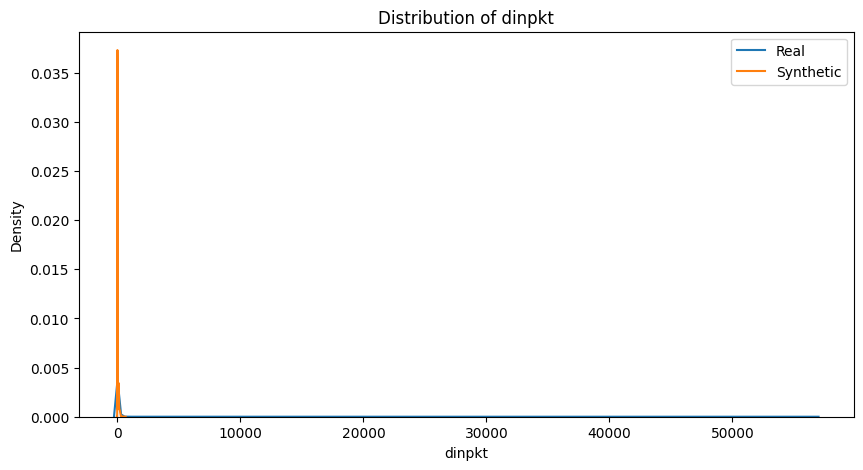

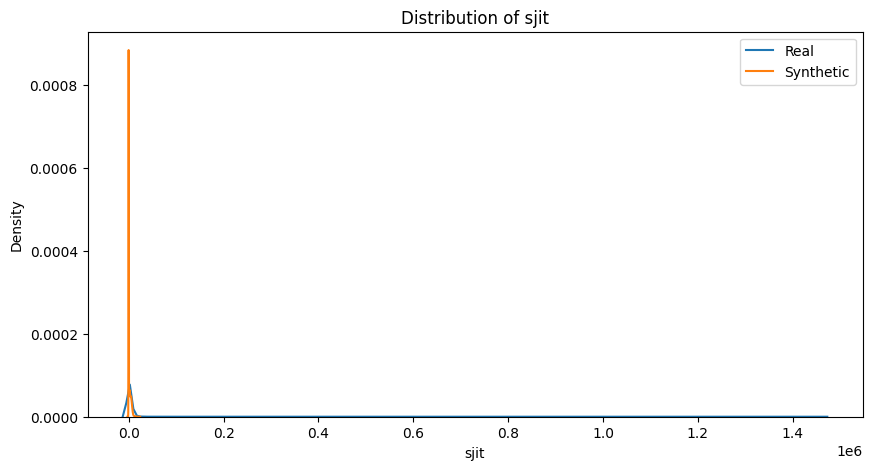

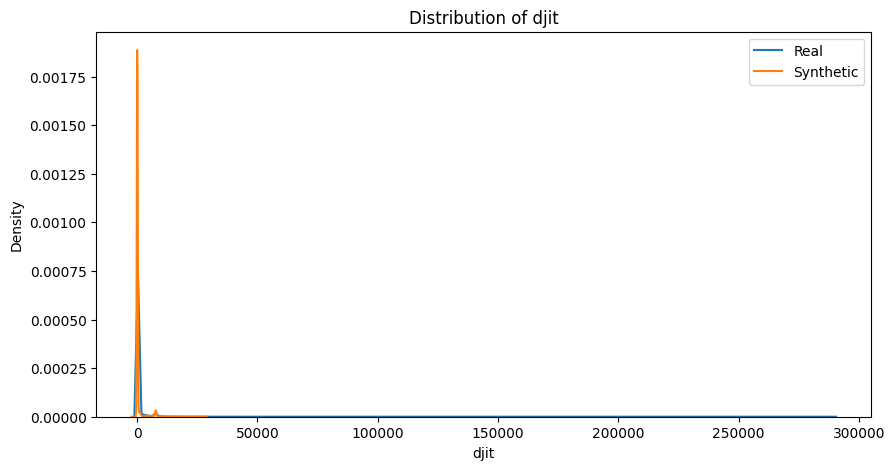

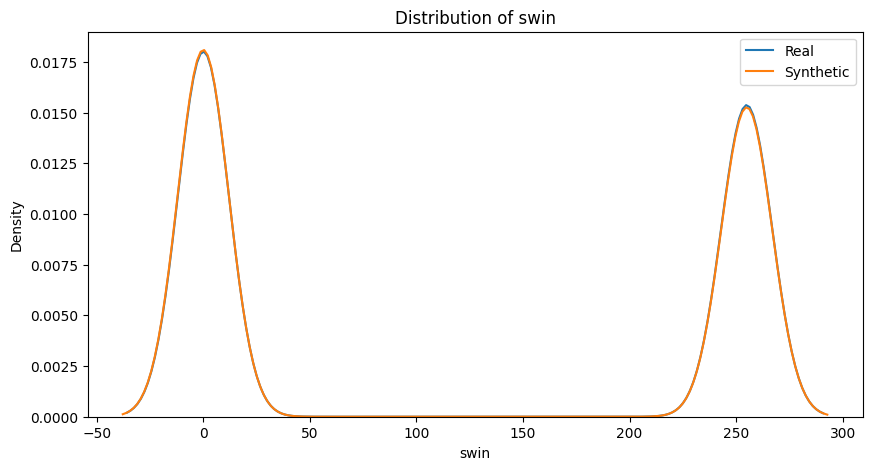

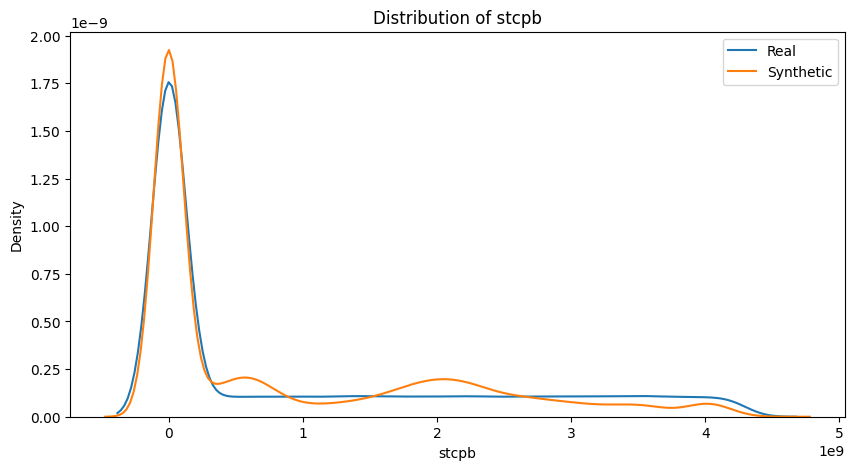

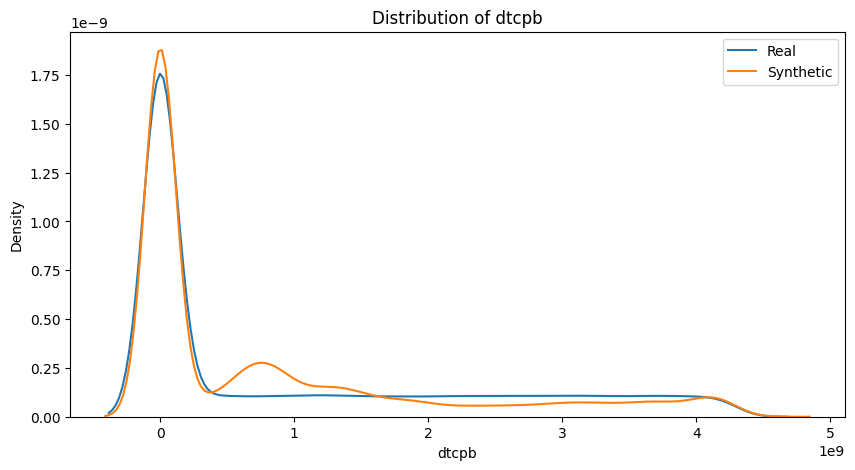

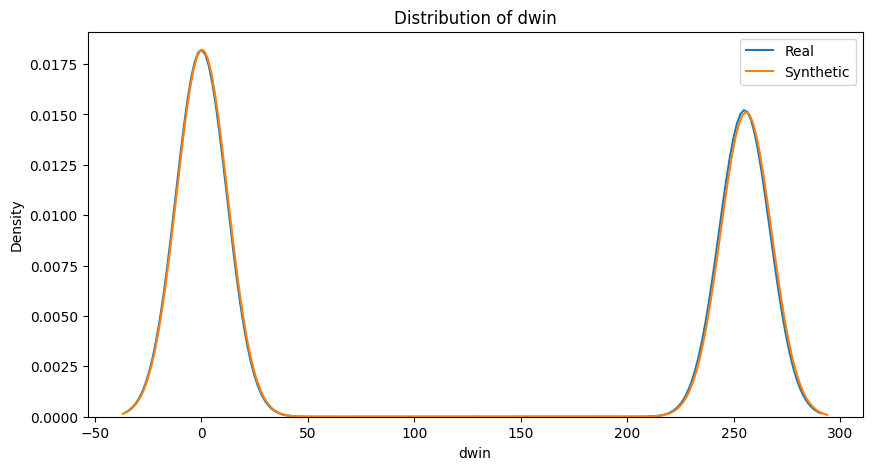

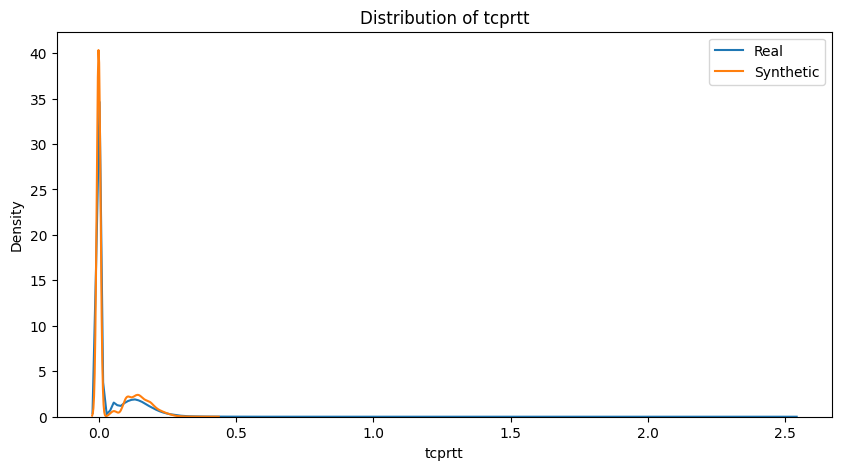

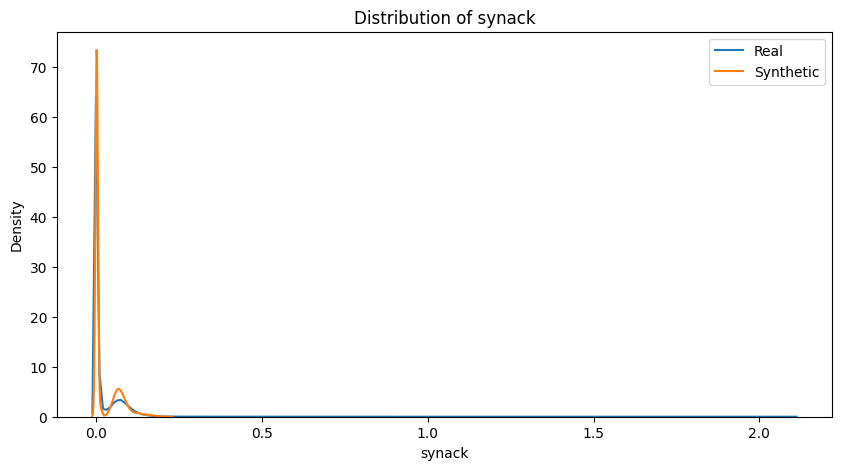

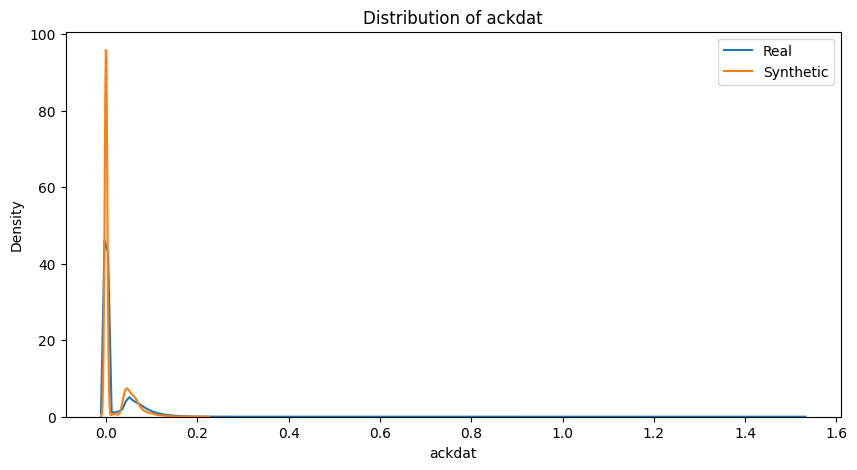

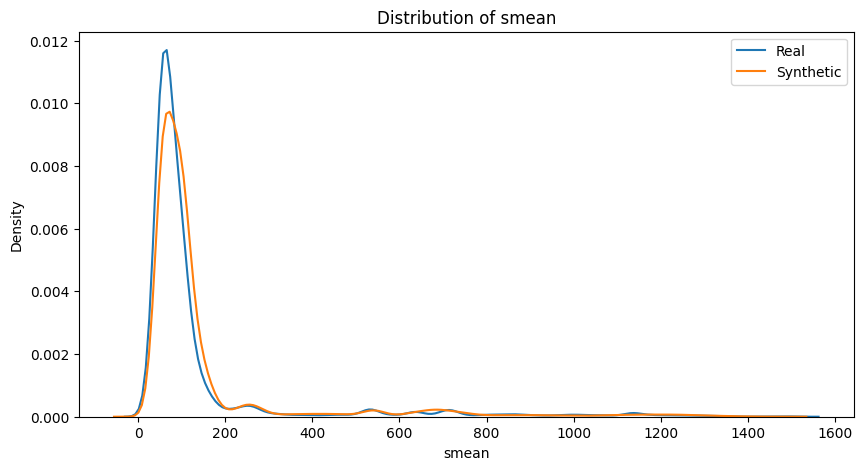

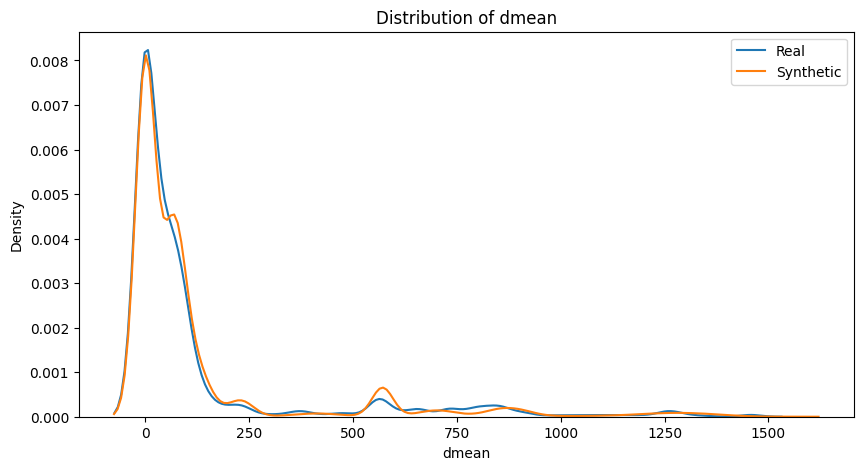

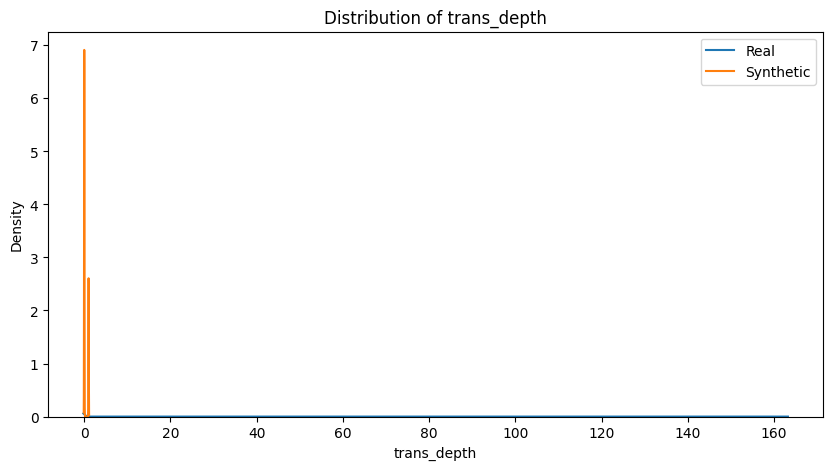

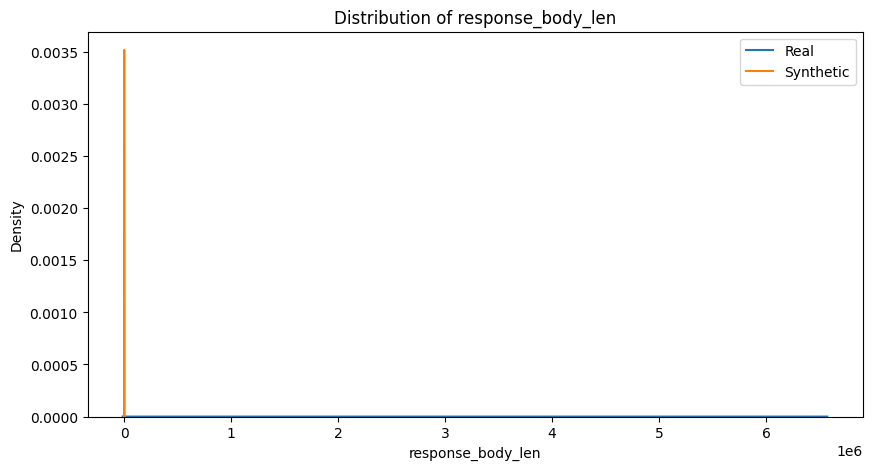

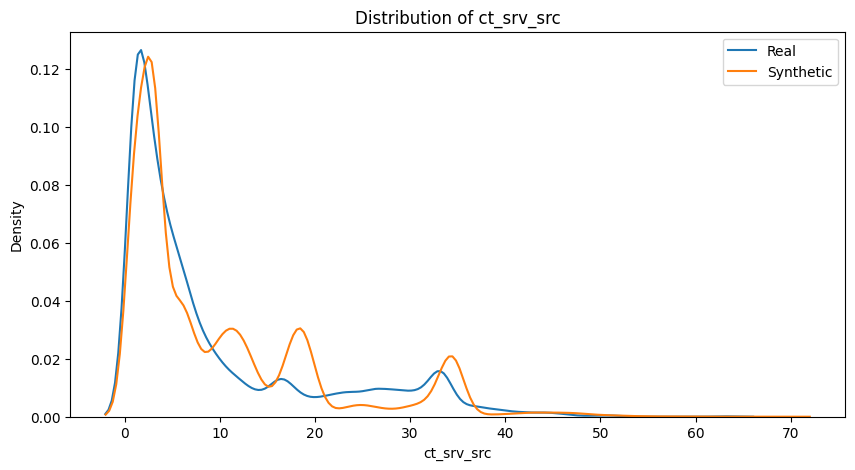

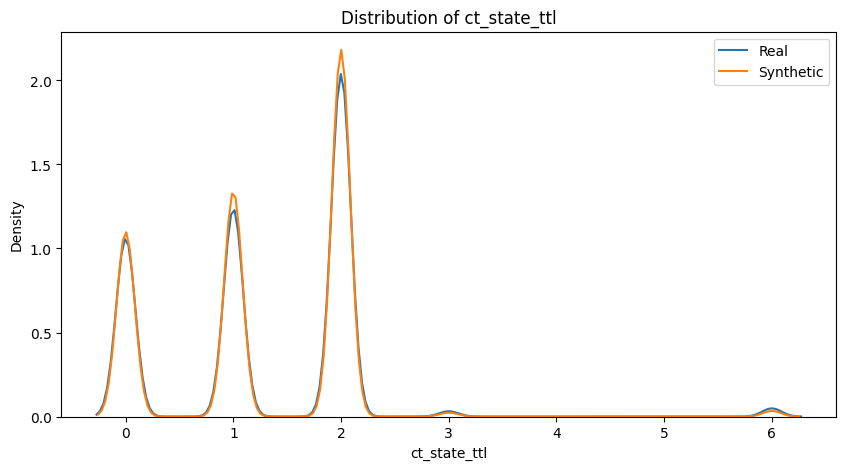

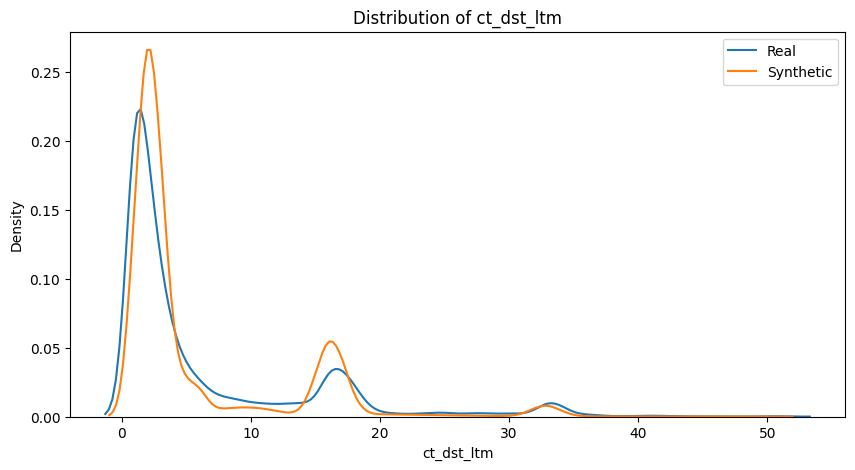

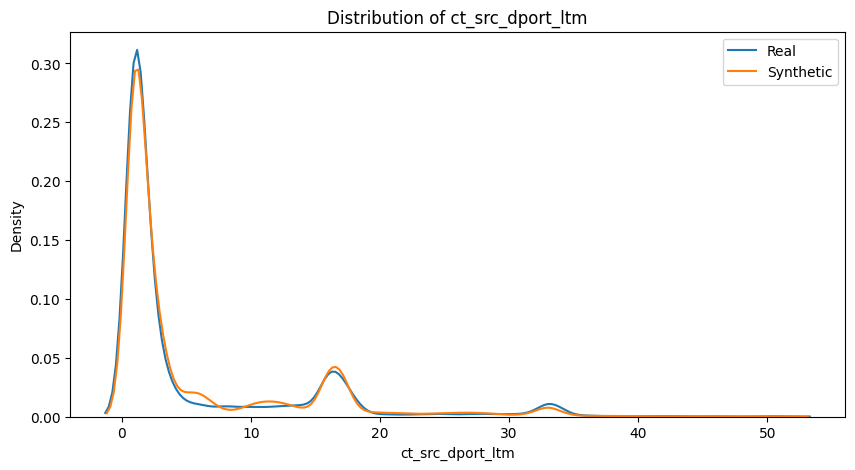

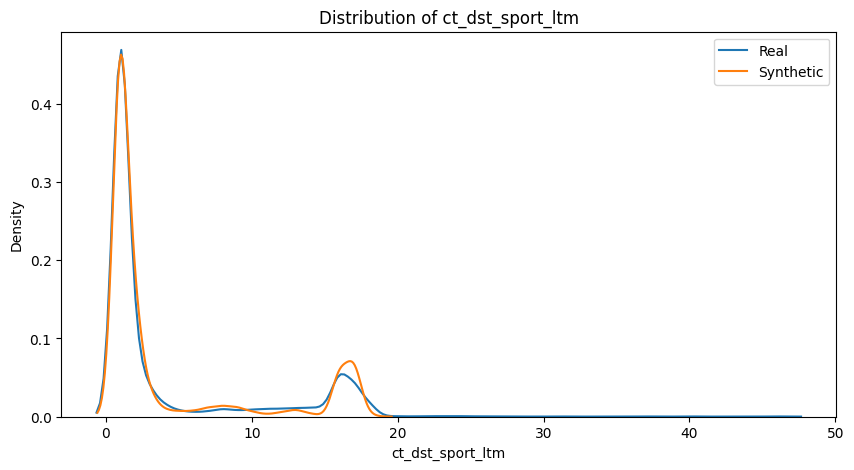

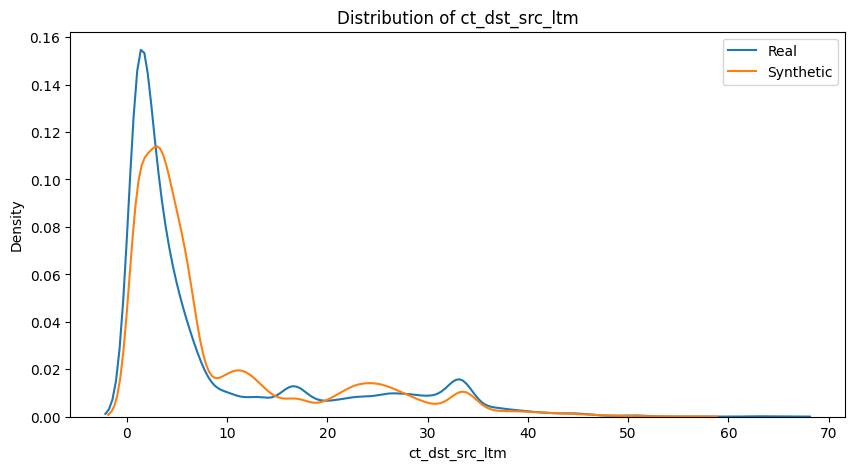

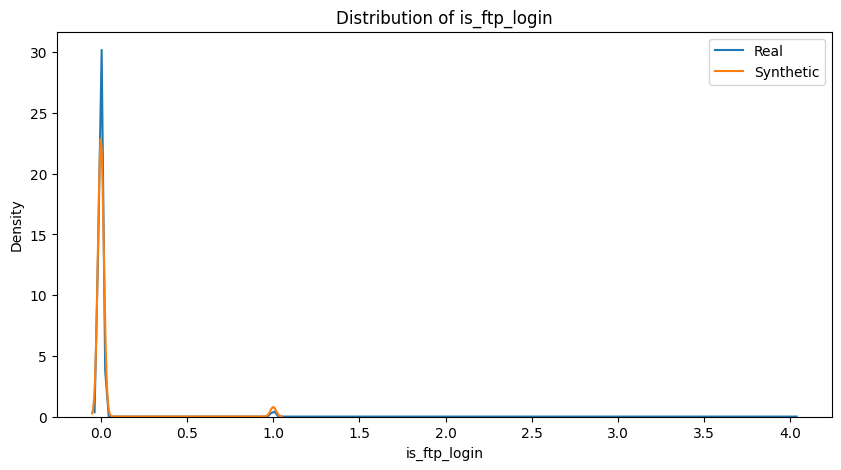

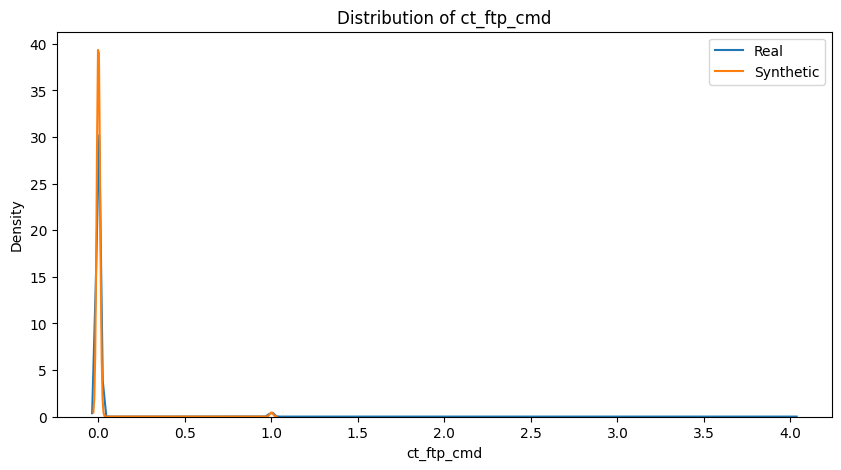

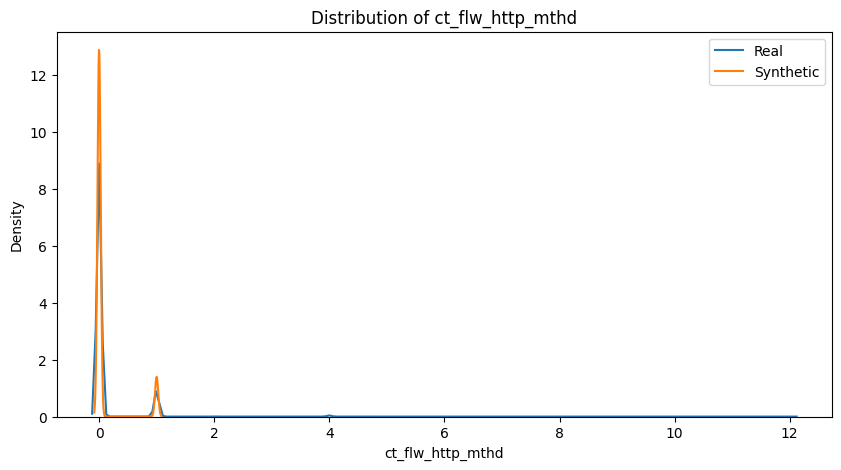

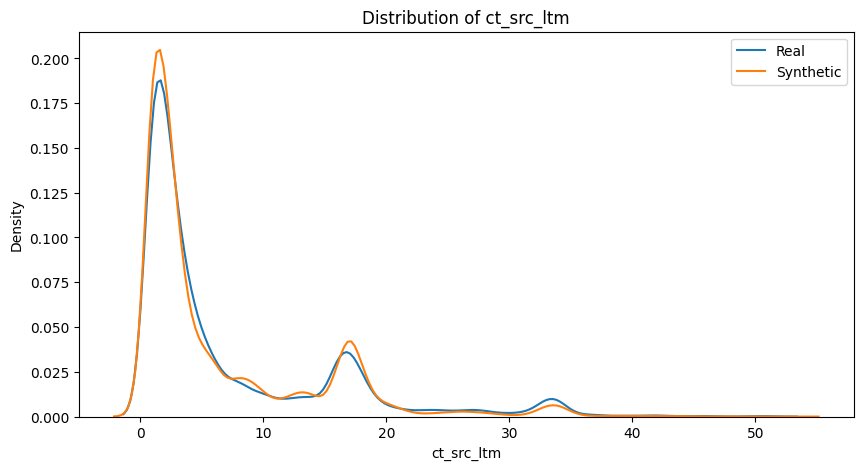

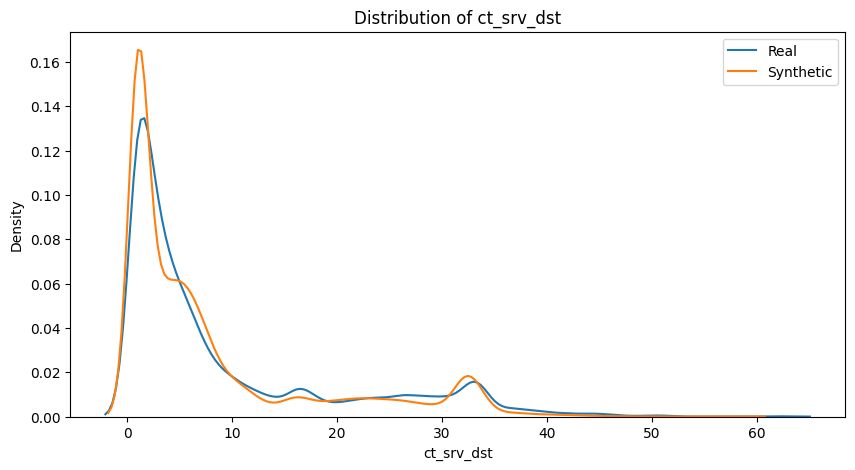

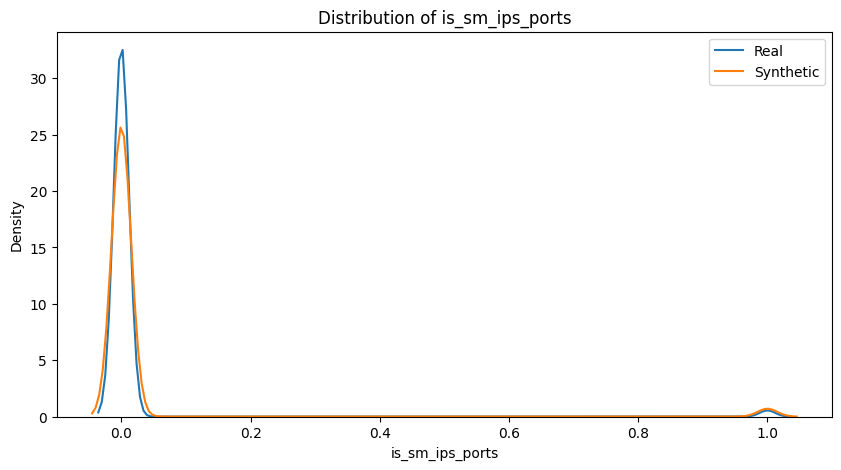

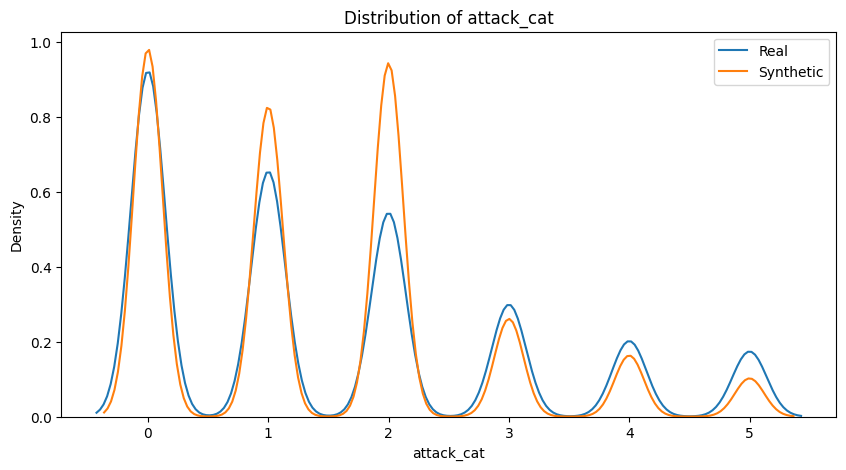

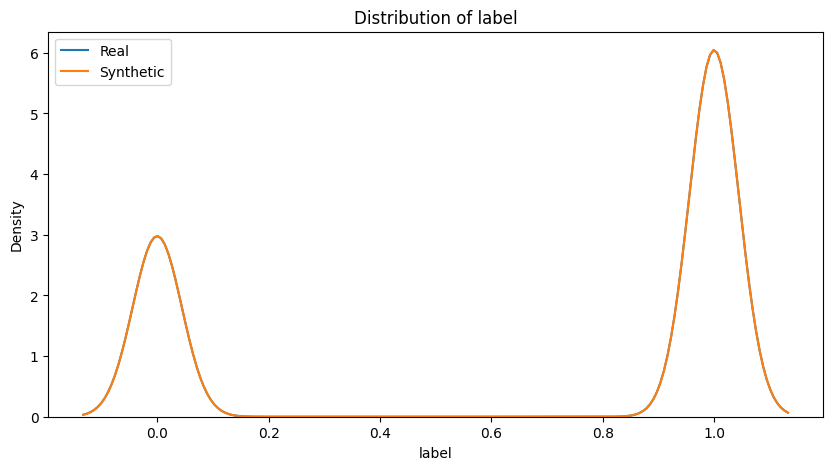

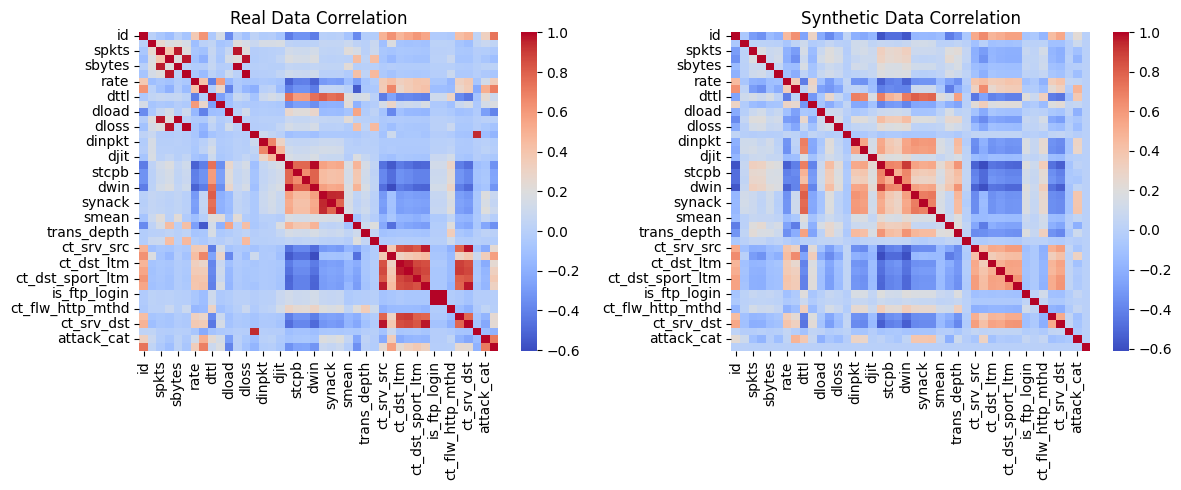

In [23]:
#Statistical Comparison: Compare distributions of individual features and relationships between features in the real and synthetic data.
import seaborn as sns
import matplotlib.pyplot as plt

def compare_distributions(real_data, synthetic_data, column):
    plt.figure(figsize=(10, 5))
    sns.kdeplot(real_data[column], label='Real')
    sns.kdeplot(synthetic_data[column], label='Synthetic')
    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.show()

# Compare distributions for each column
for column in train_data.columns:
    compare_distributions(train_data, synthetic_data, column)

# Compare correlation matrices
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.heatmap(train_data.corr(), annot=False, cmap='coolwarm')
plt.title('Real Data Correlation')
plt.subplot(122)
sns.heatmap(synthetic_data.corr(), annot=False, cmap='coolwarm')
plt.title('Synthetic Data Correlation')
plt.tight_layout()
plt.show()

In [24]:
# Load the dataset
data = pd.read_csv('synthetic_UNSW_NB15_modified_data.csv')

# Separate features and target
X = data.drop(['attack_cat'], axis=1)
y = data['attack_cat']

# Convert 'attack_cat' to integer type
y = y.astype('int32')

# Number of classes
num_classes = y.nunique()

# Convert class vectors to binary class matrices (one-hot encoding)
y = to_categorical(y, num_classes)

# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialize the ANN
model = Sequential()

# Add the input layer and the first hidden layer with dropout
model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.05))

# Add the second hidden layer with dropout
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.075))

# Add the third hidden layer with dropout
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.1))

# Add the output layer
model.add(Dense(units=num_classes, activation='softmax'))

# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the ANN
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the ANN on the training set
model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=200, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Epoch 1/200
3407/3407 [==============================] - 12s 3ms/step - loss: 0.4398 - accuracy: 0.8259 - val_loss: 0.3563 - val_accuracy: 0.8584
Epoch 2/200
3407/3407 [==============================] - 12s 3ms/step - loss: 0.3563 - accuracy: 0.8576 - val_loss: 0.3284 - val_accuracy: 0.8672
Epoch 3/200
3407/3407 [==============================] - 11s 3ms/step - loss: 0.3359 - accuracy: 0.8641 - val_loss: 0.3213 - val_accuracy: 0.8654
Epoch 4/200
3407/3407 [==============================] - 16s 5ms/step - loss: 0.3257 - accuracy: 0.8667 - val_loss: 0.3106 - val_accuracy: 0.8715
Epoch 5/200
3407/3407 [==============================] - 10s 3ms/step - loss: 0.3183 - accuracy: 0.8697 - val_loss: 0.3110 - val_accuracy: 0.8701
Epoch 6/200
3407/3407 [==============================] - 12s 3ms/step - loss: 0.3145 - accuracy: 0.8705 - val_loss: 0.3042 - val_accuracy: 0.8751
Epoch 7/200
3407/3407 [==============================] - 12s 3ms/step - loss: 0.3098 - accuracy: 0.8722 - val_loss: 0.2996 -

1065/1065 [==============================] - 3s 3ms/step


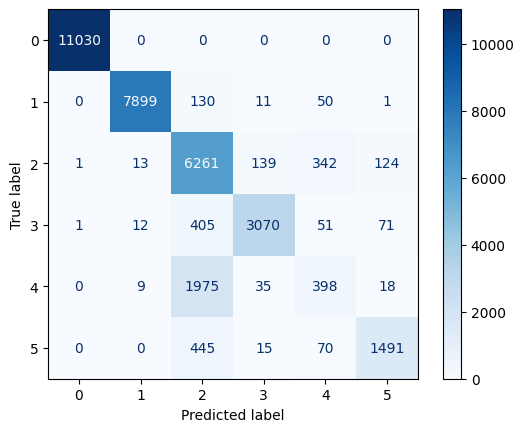

Train ROC AUC Score: 0.8771883748872131
Test ROC AUC Score: 0.8748640108339378


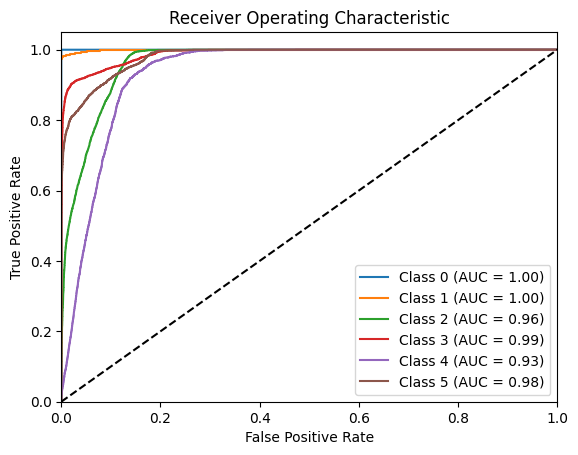

In [27]:
# Predict probabilities
y_train_prob = model.predict(X_train)
y_test_prob = model.predict(X_test)

# Convert probabilities to classes
y_train_pred = np.argmax(y_train_prob, axis=1)
y_test_pred = np.argmax(y_test_prob, axis=1)

# Confusion Matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2,3,4,5 ])# 6
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Save Confusion Matrix to .npy file
np.save('confusion_matrix_generated.npy', cm)
# Save true labels and predicted probabilities
np.save('y_test_generated.npy', np.argmax(y_test, axis=1))  # True labels
np.save('y_pred_proba_generated.npy', y_test_prob)  # Predicted probabilities

# Compute ROC AUC
lb = LabelBinarizer()
lb.fit(y_train)
y_train_lb = lb.transform(y_train)
y_test_lb = lb.transform(y_test)
y_train_pred_lb = lb.transform(y_train_pred)
y_test_pred_lb = lb.transform(y_test_pred)

roc_auc_train = roc_auc_score(y_train_lb, y_train_pred_lb, multi_class='ovr')
roc_auc_test = roc_auc_score(y_test_lb, y_test_pred_lb, multi_class='ovr')

print(f"Train ROC AUC Score: {roc_auc_train}")
print(f"Test ROC AUC Score: {roc_auc_test}")

# Save ROC AUC Scores to .npy file
roc_auc_scores = {'train': roc_auc_train, 'test': roc_auc_test}
np.save('roc_auc_scores_generated.npy', roc_auc_scores)

# Plot ROC curves
fig, ax = plt.subplots()
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_lb[:, i], y_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Class {i}')
    display.plot(ax=ax) # Plot on the same axe

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [28]:
# Define the path to save files in Google Drive
save_path = '/content/drive/My Drive/'

# Save Confusion Matrix to .npy file
np.save(save_path + 'confusion_matrix_generated.npy', cm)

# Save true labels and predicted probabilities for later use
np.save(save_path + 'y_test_generated.npy', np.argmax(y_test, axis=1))  # True labels
np.save(save_path + 'y_pred_proba_generated.npy', y_test_prob)  # Predicted probabilities

# Save ROC AUC Scores to .npy file
roc_auc_scores = {'train': roc_auc_train, 'test': roc_auc_test}
np.save(save_path + 'roc_auc_scores_generated.npy', roc_auc_scores)


**Mix the initial data with the generated data, retrain the model on this hybrid dataset**

In [29]:
# Load the initial and generated datasets
initial_data = pd.read_csv('modified_data.csv')
generated_data = pd.read_csv('synthetic_UNSW_NB15_modified_data.csv')

# Create the hybrid dataset (50% initial, 50% generated)
initial_sample = initial_data.sample(frac=0.5, random_state=42)
generated_sample = generated_data.sample(n=len(initial_sample), random_state=42)
hybrid_data = pd.concat([initial_sample, generated_sample], axis=0).reset_index(drop=True)

#save the hybrid dataset
hybrid_data.to_csv('hybrid_data.csv', index=False)

# Load the dataset
data = pd.read_csv('hybrid_data.csv')

# Separate features and target
X = data.drop(['attack_cat'], axis=1)
y = data['attack_cat']

# Convert 'attack_cat' to integer type
y = y.astype('int32')

# Number of classes
num_classes = y.nunique()

# Convert class vectors to binary class matrices (one-hot encoding)
y = to_categorical(y, num_classes)

# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialize the ANN
model = Sequential()

# Add the input layer and the first hidden layer with dropout
model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.05))

# Add the second hidden layer with dropout
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.075))

# Add the third hidden layer with dropout
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.1))

# Add the output layer
model.add(Dense(units=num_classes, activation='softmax'))

# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the ANN
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the ANN on the training set
model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=200, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Epoch 1/200
3407/3407 [==============================] - 14s 4ms/step - loss: 0.4258 - accuracy: 0.8319 - val_loss: 0.3515 - val_accuracy: 0.8562
Epoch 2/200
3407/3407 [==============================] - 10s 3ms/step - loss: 0.3510 - accuracy: 0.8592 - val_loss: 0.3327 - val_accuracy: 0.8609
Epoch 3/200
3407/3407 [==============================] - 10s 3ms/step - loss: 0.3310 - accuracy: 0.8658 - val_loss: 0.3239 - val_accuracy: 0.8685
Epoch 4/200
3407/3407 [==============================] - 12s 3ms/step - loss: 0.3216 - accuracy: 0.8679 - val_loss: 0.3079 - val_accuracy: 0.8725
Epoch 5/200
3407/3407 [==============================] - 11s 3ms/step - loss: 0.3144 - accuracy: 0.8719 - val_loss: 0.3035 - val_accuracy: 0.8728
Epoch 6/200
3407/3407 [==============================] - 9s 3ms/step - loss: 0.3101 - accuracy: 0.8725 - val_loss: 0.3061 - val_accuracy: 0.8710
Epoch 7/200
3407/3407 [==============================] - 11s 3ms/step - loss: 0.3053 - accuracy: 0.8730 - val_loss: 0.3021 - 

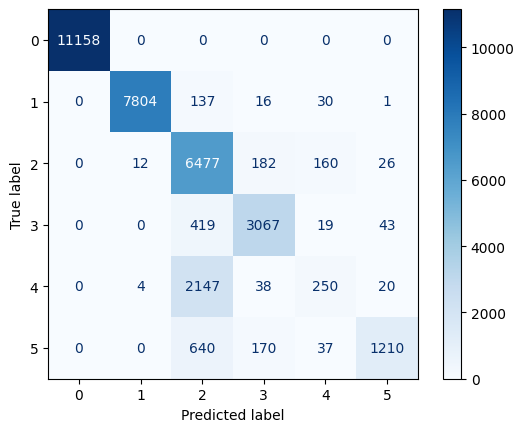

Train ROC AUC Score: 0.862138387662502
Test ROC AUC Score: 0.8607092098318074


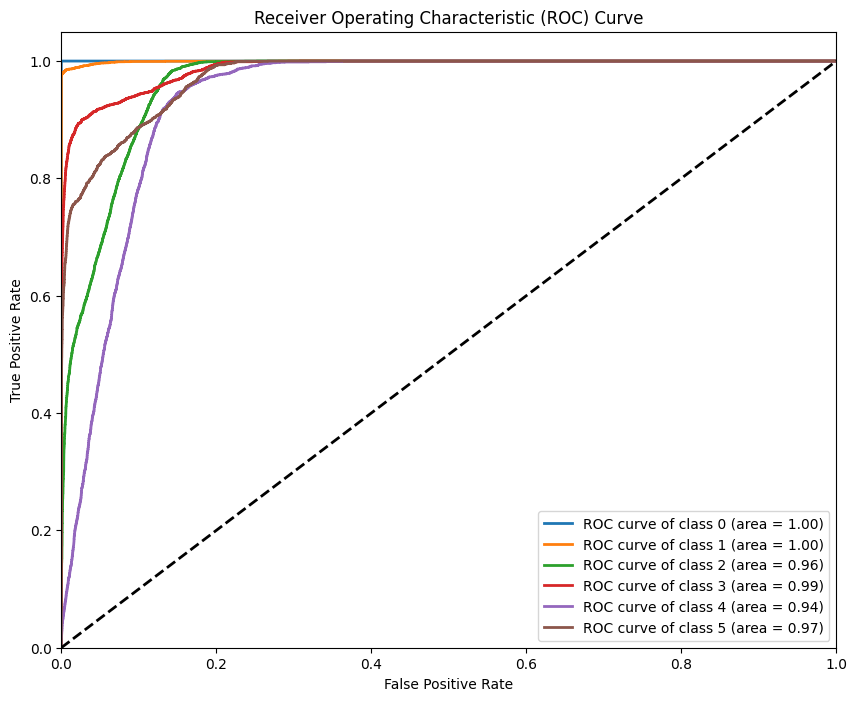

Average AUC-ROC: 0.9766


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer

# Load the saved data
cm = np.load('confusion_matrix_hybrid.npy')
y_test_hybrid = np.load('y_test_hybrid.npy')
y_pred_proba_hybrid = np.load('y_pred_proba_hybrid.npy')
roc_auc_scores = np.load('roc_auc_scores_hybrid.npy', allow_pickle=True).item()

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5])  # Adjust labels if necessary
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print ROC AUC Scores
print(f"Train ROC AUC Score: {roc_auc_scores['train']}")
print(f"Test ROC AUC Score: {roc_auc_scores['test']}")

# Iterate over each class for ROC calculation
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = y_pred_proba_hybrid.shape[1]

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_hybrid == i, y_pred_proba_hybrid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate and print average AUC-ROC
average_auc = np.mean(list(roc_auc.values()))
print(f"Average AUC-ROC: {average_auc:.4f}")

In [35]:
# Define the path to save files in Google Drive
save_path = '/content/drive/My Drive/'

# Save Confusion Matrix to .npy file
np.save(save_path + 'confusion_matrix_hybrid.npy', cm)

# Save true labels and predicted probabilities for later use
np.save(save_path + 'y_test_hybrid.npy', np.argmax(y_test, axis=1))  # True labels
np.save(save_path + 'y_pred_proba_hybrid.npy', y_test_prob)  # Predicted probabilities

# Save ROC AUC Scores to .npy file
roc_auc_scores = {'train': roc_auc_train, 'test': roc_auc_test}
np.save(save_path + 'roc_auc_scores_hybrid.npy', roc_auc_scores)


**Comparison of the 03 dataset performance**

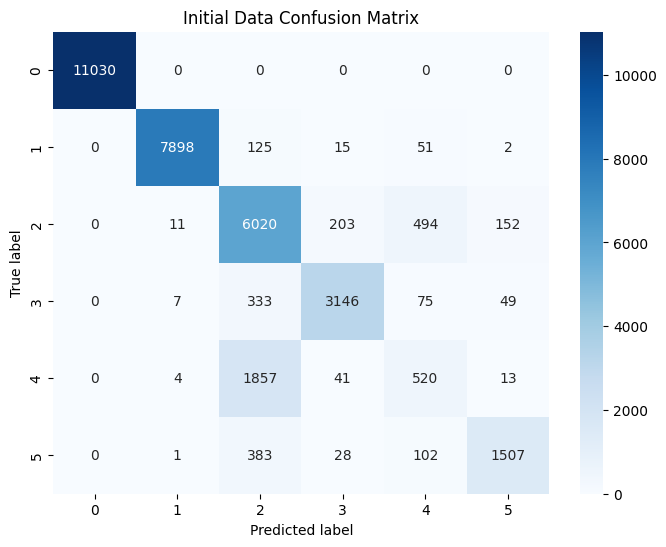

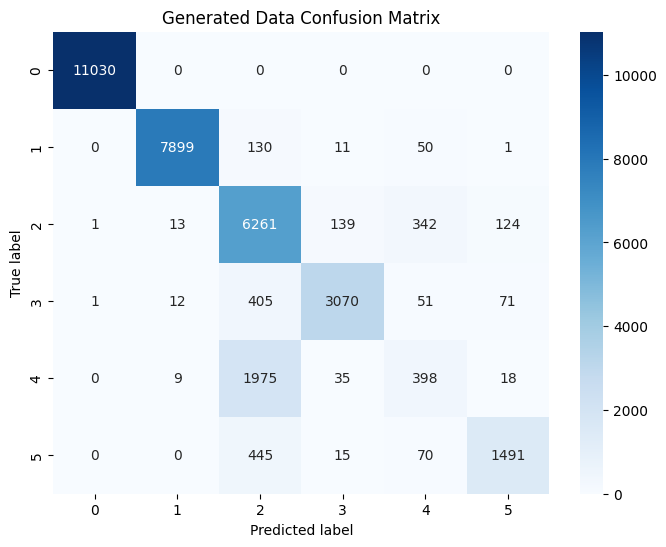

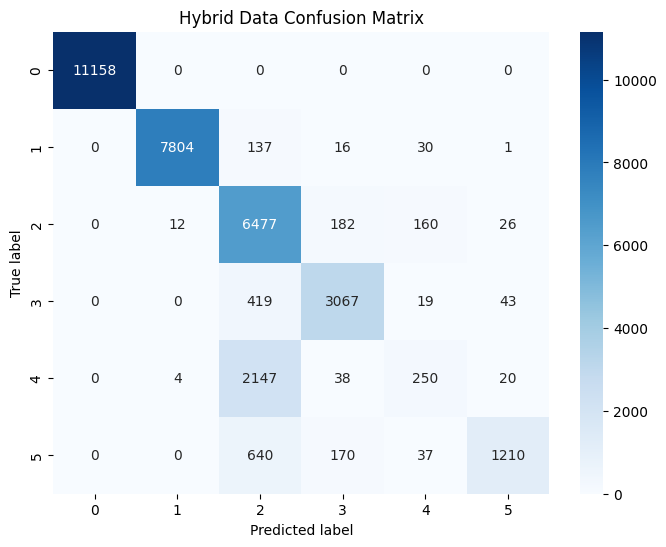

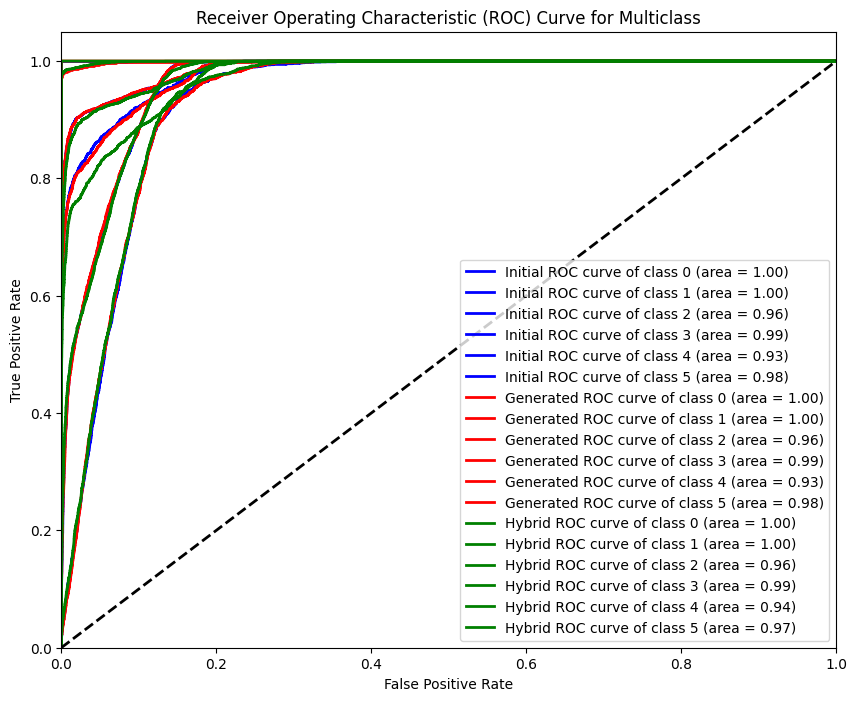

Average AUC-ROC for Initial Data: 0.9776
Average AUC-ROC for Generated Data: 0.9776
Average AUC-ROC for Hybrid Data: 0.9766


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Load the results
confusion_matrix_initial = np.load('confusion_matrix_initial.npy')
y_test_initial = np.load('y_test_initial.npy')
y_pred_proba_initial = np.load('y_pred_proba_initial.npy')

confusion_matrix_generated = np.load('confusion_matrix_generated.npy')
y_test_generated = np.load('y_test_generated.npy')
y_pred_proba_generated = np.load('y_pred_proba_generated.npy')

confusion_matrix_hybrid = np.load('confusion_matrix_hybrid.npy')
y_test_hybrid = np.load('y_test_hybrid.npy')
y_pred_proba_hybrid = np.load('y_pred_proba_hybrid.npy')

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(confusion_matrix_initial, "Initial Data Confusion Matrix")
plot_confusion_matrix(confusion_matrix_generated, "Generated Data Confusion Matrix")
plot_confusion_matrix(confusion_matrix_hybrid, "Hybrid Data Confusion Matrix")

# Get the number of classes
n_classes = y_pred_proba_initial.shape[1]

# Binarize the output
y_test_initial_bin = label_binarize(y_test_initial, classes=range(n_classes))
y_test_generated_bin = label_binarize(y_test_generated, classes=range(n_classes))
y_test_hybrid_bin = label_binarize(y_test_hybrid, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

datasets = ['Initial', 'Generated', 'Hybrid']
y_tests = [y_test_initial_bin, y_test_generated_bin, y_test_hybrid_bin]
y_pred_probas = [y_pred_proba_initial, y_pred_proba_generated, y_pred_proba_hybrid]

for i, dataset in enumerate(datasets):
    fpr[dataset] = dict()
    tpr[dataset] = dict()
    roc_auc[dataset] = dict()
    for j in range(n_classes):
        fpr[dataset][j], tpr[dataset][j], _ = roc_curve(y_tests[i][:, j], y_pred_probas[i][:, j])
        roc_auc[dataset][j] = auc(fpr[dataset][j], tpr[dataset][j])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
for i, dataset in enumerate(datasets):
    for j in range(n_classes):
        plt.plot(fpr[dataset][j], tpr[dataset][j], color=colors[i], lw=2,
                 label=f'{dataset} ROC curve of class {j} (area = {roc_auc[dataset][j]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc="lower right")
plt.show()

# Print average AUC-ROC scores
for dataset in datasets:
    print(f"Average AUC-ROC for {dataset} Data: {np.mean(list(roc_auc[dataset].values())):.4f}")

In [40]:
# Function to load data and calculate AUC-ROC for each dataset
def load_and_calculate_auc(dataset_name):
    y_test = np.load(f'y_test_{dataset_name}.npy')
    y_pred_proba = np.load(f'y_pred_proba_{dataset_name}.npy')

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    num_classes = y_pred_proba.shape[1]

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    average_auc = np.mean(list(roc_auc.values()))

    return fpr, tpr, roc_auc, average_auc

# Load and calculate for all datasets
datasets = ['initial', 'generated', 'hybrid']
results = {}

for dataset in datasets:
    results[dataset] = load_and_calculate_auc(dataset)

# Determine which dataset performed best
average_aucs = {dataset: results[dataset][3] for dataset in datasets}
best_dataset = max(average_aucs, key=average_aucs.get)

print("\nAverage AUC-ROC scores:")
for dataset, avg_auc in average_aucs.items():
    print(f"{dataset.capitalize()} Dataset: {avg_auc:.4f}")

print(f"\nThe best performing dataset is: {best_dataset.capitalize()} (AUC-ROC: {average_aucs[best_dataset]:.4f})")

# Calculate performance improvement
baseline_auc = average_aucs['initial']
best_auc = average_aucs[best_dataset]
improvement = (best_auc - baseline_auc) / baseline_auc * 100

print(f"\nPerformance improvement over initial dataset: {improvement:.2f}%")


Average AUC-ROC scores:
Initial Dataset: 0.9776
Generated Dataset: 0.9776
Hybrid Dataset: 0.9766

The best performing dataset is: Initial (AUC-ROC: 0.9776)

Performance improvement over initial dataset: 0.00%
